
# Linear Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a linear regression activity.

Workflow:



1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [97]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model, feature_selection
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.xlsx` file and show a short description

In [98]:
# This cell allows full compatibility between execution in Google Colab and in local
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()

In [99]:
# The file must be available in the same directory, 
# or uploaded in the Colab environment 
# in the execution of the previous cell
data_fn = 'FoodUK2014.xlsx'
df0 = pd.read_excel(data_fn)

## Data Exploration and preparation

##### Show a short description of the columns

In [100]:
df0.describe()

,hhsize,adults_n,children_n,totalexp,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.0,5114.000000,5114.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000
mean,2.363707,1.841807,0.521901,519.898868,2014.0,679.542002,53.802698,10.475023,2.146960,25.727801,68.108342,19.635469,58.943391,7.072523,9.934257,2.508315
std,1.244704,0.743052,0.945622,411.543093,0.0,499.596175,16.187912,8.798118,2.034353,18.371345,57.347230,18.725096,44.751694,2.931651,5.485175,1.358023
min,1.000000,0.000000,0.000000,-246.916821,2014.0,0.000000,17.000000,0.086667,0.108333,0.060667,0.195000,0.000000,0.520000,0.357694,0.000000,0.159672
25%,1.000000,1.000000,0.000000,260.598783,2014.0,306.954000,41.000000,4.452500,0.866667,12.222167,29.141668,6.917083,27.148333,5.171614,5.979375,1.760525
50%,2.000000,2.000000,0.000000,426.977227,2014.0,548.086000,54.000000,8.374167,1.625000,22.245817,54.708336,13.736667,49.356667,6.575851,8.804690,2.254208
75%,3.000000,2.000000,1.000000,651.003763,2014.0,925.652500,67.000000,14.005333,2.816667,35.037167,90.480003,26.000000,78.281662,8.295746,12.520942,2.893561
max,9.000000,7.000000,7.000000,5859.877186,2014.0,2134.090000,80.000000,104.589333,41.348362,169.283829,803.465027,194.869995,480.024994,40.000000,46.315834,32.666668


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [101]:
n, d = df0.shape # n = number of rows, d = number of columns
n_notnull = min(df0.describe().loc['count']) # Minimum number of rows without nulls
print(n - n_notnull)

1572.0


#### Drop rows with nulls

In [102]:
df1 = df0.drop(df0[df0.isnull().any(axis=1)].index)
df1.shape

(3446, 20)

##### Data transormation
- Convert the alphanumeric SexHRP into numeric 0 and 1
    - the `sklearn` machine learning procedures work only with numeric predicting
      attributes
- Generate two new columns as ratio of other columns
    - this is suggested by background information

In [103]:
print(np.unique(df1['SexHRP']))

['Female' 'Male']


In [104]:
# Define dictionary for the replacement
to_replace = {
    'Female': 0,
    'Male': 1
}

# Replace with the define dictionary
df1['SexHRP'] = df1['SexHRP'].replace(to_replace=to_replace)
df1

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
1,4,July to September,2,2,737.685635,1,August,North East,2014,824.520,38,6.045000,0.650000,30.203335,53.278336,6.500000,62.833336,8.813621,10.000000,2.080344
2,2,October to December,2,0,330.775000,1,October,Northern Ireland,2014,271.925,54,11.780167,2.088667,17.032166,93.838333,28.491667,42.813335,7.965790,13.641079,2.513675
4,3,April to June,3,0,880.787157,1,April,East Midlands,2014,496.040,64,12.857000,2.903333,7.345000,73.623337,16.921667,19.261665,5.726323,5.828358,2.622419
5,4,January to March,2,2,372.275578,1,February,Wales,2014,266.530,70,35.873001,1.789667,27.378000,303.181671,28.773333,86.558327,8.451528,16.077482,3.161602
7,3,January to March,3,0,151.750522,1,January,Eastern,2014,403.180,64,12.237333,3.003000,6.742667,72.258331,26.000000,17.376667,5.904745,8.658009,2.577121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,2,October to December,2,0,421.689215,1,November,East Midlands,2014,679.805,61,13.549467,2.470000,21.894167,98.973328,14.386666,38.761669,7.304593,5.824561,1.770411
5110,2,July to September,2,0,2027.628194,1,August,South East,2014,2134.090,71,7.473050,1.581667,33.303185,114.161667,20.193335,109.958328,15.276449,12.767123,3.301736
5111,1,January to March,1,0,207.149193,1,March,Eastern,2014,326.490,33,0.866667,1.386667,7.919167,3.575000,9.750000,28.058332,4.125000,7.031250,3.543092
5112,1,January to March,1,0,299.725739,0,January,Eastern,2014,358.680,70,1.566500,2.015000,12.137646,15.145000,15.881666,31.936668,9.668050,7.881721,2.631208


In [105]:
df1['qmeat_hhsize_ratio'] = df1['qmeat'] / df1['hhsize']
df1['income_hhsize_ratio'] = df1['income'] / df1['hhsize']
df1

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,...,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv,qmeat_hhsize_ratio,income_hhsize_ratio
1,4,July to September,2,2,737.685635,1,August,North East,2014,824.520,...,0.650000,30.203335,53.278336,6.500000,62.833336,8.813621,10.000000,2.080344,1.511250,206.130000
2,2,October to December,2,0,330.775000,1,October,Northern Ireland,2014,271.925,...,2.088667,17.032166,93.838333,28.491667,42.813335,7.965790,13.641079,2.513675,5.890083,135.962500
4,3,April to June,3,0,880.787157,1,April,East Midlands,2014,496.040,...,2.903333,7.345000,73.623337,16.921667,19.261665,5.726323,5.828358,2.622419,4.285667,165.346667
5,4,January to March,2,2,372.275578,1,February,Wales,2014,266.530,...,1.789667,27.378000,303.181671,28.773333,86.558327,8.451528,16.077482,3.161602,8.968250,66.632500
7,3,January to March,3,0,151.750522,1,January,Eastern,2014,403.180,...,3.003000,6.742667,72.258331,26.000000,17.376667,5.904745,8.658009,2.577121,4.079111,134.393333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,2,October to December,2,0,421.689215,1,November,East Midlands,2014,679.805,...,2.470000,21.894167,98.973328,14.386666,38.761669,7.304593,5.824561,1.770411,6.774734,339.902500
5110,2,July to September,2,0,2027.628194,1,August,South East,2014,2134.090,...,1.581667,33.303185,114.161667,20.193335,109.958328,15.276449,12.767123,3.301736,3.736525,1067.045000
5111,1,January to March,1,0,207.149193,1,March,Eastern,2014,326.490,...,1.386667,7.919167,3.575000,9.750000,28.058332,4.125000,7.031250,3.543092,0.866667,326.490000
5112,1,January to March,1,0,299.725739,0,January,Eastern,2014,358.680,...,2.015000,12.137646,15.145000,15.881666,31.936668,9.668050,7.881721,2.631208,1.566500,358.680000


##### Use only the columns that the experts consider interesting
This is suggested by background information

In [106]:
df2 = df1[['adults_n', 'children_n', 'SexHRP', 'AgeHRP', 'qmeat_hhsize_ratio', 'income_hhsize_ratio', 'uvmeat']]
df2

,adults_n,children_n,SexHRP,AgeHRP,qmeat_hhsize_ratio,income_hhsize_ratio,uvmeat
1,2,2,1,38,1.511250,206.130000,8.813621
2,2,0,1,54,5.890083,135.962500,7.965790
4,3,0,1,64,4.285667,165.346667,5.726323
5,2,2,1,70,8.968250,66.632500,8.451528
7,3,0,1,64,4.079111,134.393333,5.904745
...,...,...,...,...,...,...,...
5109,2,0,1,61,6.774734,339.902500,7.304593
5110,2,0,1,71,3.736525,1067.045000,15.276449
5111,1,0,1,33,0.866667,326.490000,4.125000
5112,1,0,0,70,1.566500,358.680000,9.668050


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [107]:
X = df2[['adults_n', 'children_n', 'SexHRP', 'AgeHRP', 'income_hhsize_ratio', 'uvmeat']]
y = df2['qmeat_hhsize_ratio']

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

In [108]:
ncols=3
import math
nrows = math.ceil((X.shape[1]-1)/ncols)
figwidth = ncols * 7
figheigth = nrows*5

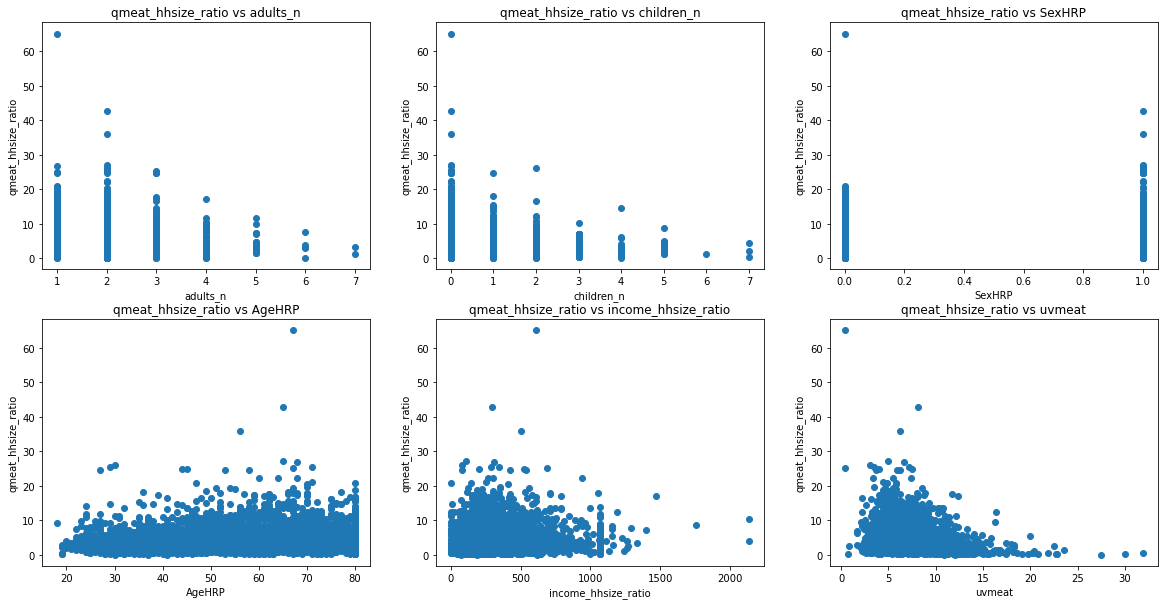

In [109]:
plt.figure(figsize=(20, 10))            # Set figure size
for (i, col) in zip(range(len(X.columns)), X.columns):
    plt.subplot(nrows, ncols, i+1)      # Set the subplot

    plt.title(y.name + " vs " + col)    # Title
    plt.xlabel(col)                     # X axis name
    plt.ylabel(y.name)                  # Y axis name

    plt.scatter(X[col], y)              # Plot data
plt.show()                              # Final show


### Show the *_p-values_* of the target with respect to the variables

In [110]:
from sklearn.feature_selection import f_regression
# Your code here
fstat, p_vals = feature_selection.f_regression(X, y)
df_pvals = pd.DataFrame()
df_pvals['Variable'] = ['adults_n', 'children_n', 'SexHRP', 'AgeHRP', 'income_hhsize_ratio', 'uvmeat']
df_pvals['p-value'] = p_vals
df_pvals

,Variable,p-value
0,adults_n,1.415945e-05
1,children_n,1.077386e-30
2,SexHRP,8.429827e-02
3,AgeHRP,1.710126e-21
4,income_hhsize_ratio,1.211099e-03
5,uvmeat,4.789746e-52


## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
print(X_train.shape, X_test.shape)

(2412, 6) (1034, 6)


### Consider a reduced dataset containing the chosen variable and the target

In [112]:
chosen_var = 'adults_n'
X_train_reduced = np.array(X_train[chosen_var])
X_test_reduced = np.array(X_test[chosen_var])

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [113]:
estimator = linear_model.LinearRegression()
estimator.fit(X_train_reduced.reshape(-1, 1), y_train)
y_train_pred = estimator.predict(X_train_reduced.reshape(-1, 1))
y_test_pred = estimator.predict(X_test_reduced.reshape(-1, 1))

#### Compute the regression coefficients and the quality measures
Create a function to compute the F-statistic and p-value of the regression model

In [114]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def F_test(y_true, y_pred, n_var, n_obs):
    n = n_obs       # Number of samples
    p = n_var+1     # Degree of the polynomio

    SSM = sum(((y_pred - np.mean(y_true))**2))
    SSE = sum((y_true.values - y_pred)**2)

    DFM = p - 1
    DFE = n - p

    fstat = round((SSM/DFM) / (SSE/DFE), 4)

    p_val = 1-scipy.stats.f.cdf(fstat, DFM, DFE) #find p-value of F test statistic 

    return fstat, p_val

In [118]:
F_test(y_train, y_train_pred, X_train_reduced.reshape(-1, 1).shape[1], X_train_reduced.reshape(-1, 1).shape[0])

(9.8412, 0.0017270651976781792)

Or use statistical software to compute it

In [119]:
fstat, p_vals = feature_selection.f_regression(X_train_reduced.reshape(-1,1), y_train)
fstat

array([9.84116238])

#### Compute the statistical significance of the model

In [120]:
from sklearn.metrics import mean_squared_error

df_sig = pd.DataFrame(index=[
    f'Intercept for \"{chosen_var}\"',
    f'Coefficient for \"{chosen_var}\"',
    'rmse',
    'r2',
    'f-statistic',
    'p-value'
])

df_sig['Univariate Linear - Value'] = [
    estimator.intercept_,
    estimator.coef_[0],
    mean_squared_error(y_test, y_test_pred, squared=False),
    estimator.score(X_test_reduced.reshape(-1, 1), y_test),
    fstat[0],
    p_vals[0]
]
# If we don't set squared=False we get the MSE, not the RMSE

df_sig

,Univariate Linear - Value
"Intercept for ""adults_n""",5.646984
"Coefficient for ""adults_n""",-0.326893
rmse,3.886323
r2,0.007595
f-statistic,9.841162
p-value,0.001727


## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [121]:
estimator = linear_model.LinearRegression()
estimator.fit(X_train, y_train)
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [122]:
estimator = linear_model.LinearRegression()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

coefsDF = pd.DataFrame({
    'Variable': X_train.columns,
    'Coefficient': estimator.coef_
})
coefsDF

,Variable,Coefficient
0,adults_n,-0.318682
1,children_n,-0.650924
2,SexHRP,0.383162
3,AgeHRP,0.014913
4,income_hhsize_ratio,0.000989
5,uvmeat,-0.392620


#### Compute the statistical significance

In [123]:
fstat, p_vals = feature_selection.f_regression(X_train, y_train_pred)
df = pd.DataFrame({
    'Variable': X.columns,
    'p-value': p_vals
})
df

,Variable,p-value
0,adults_n,4.812836e-19
1,children_n,1.384315e-188
2,SexHRP,5.806116e-10
3,AgeHRP,3.199609e-119
4,income_hhsize_ratio,6.460728e-08
5,uvmeat,0.000000e+00


#### Compute the quality measures

In [130]:
fstat, p_val = F_test(y_train, y_train_pred, X_train.shape[1], X_train.shape[0])

In [132]:
qual_mes = pd.DataFrame({
    'Univariate Linear - Value': [
        mean_squared_error(y_test, y_test_pred, squared=False),
        r2_score(y_test, y_test_pred),
        fstat,
        p_val
    ]
}, index=[
    'rmse',
    'r2',
    'f-statistic',
    'p-value'
]).style.format(precision=4)

qual_mes

,Univariate Linear - Value
rmse,3.6651
r2,0.1173
f-statistic,57.4179
p-value,0.0000


## Decision Tree Multivariate Regresson

In [133]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [138]:
estimator = DecisionTreeRegressor()
estimator.fit(X_train, y_train)
print(f"The maximum depth of the full Decision Tree Regressor is {estimator.get_depth()}")

The maximum depth of the full Decision Tree Regressor is 34


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [142]:
from sklearn import metrics
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [144]:
from sklearn.model_selection import GridSearchCV
max_depth = estimator.get_depth()
clf = GridSearchCV(estimator, param_grid=[{'max_depth': np.arange(max_depth+1)}], scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

c:\Users\aeste\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 175.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aeste\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aeste\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1342, in fit
    super().fit(
  File "c:\Users\aeste\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 238, in fit
    check_scalar(
  File "c:\Users\aeste\anaconda3\lib\site-packages\sklearn\utils\validation.py", line

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])}],
             scoring='neg_mean_squared_error')

In [146]:
print(f"The optimal maximum depth for the decision tree is {clf.best_params_['max_depth']}")

The optimal maximum depth for the decision tree is 2


In [157]:
estimator = DecisionTreeRegressor(max_depth=2)
estimator.fit(X_train, y_train)
y_test_pred = estimator.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Decision Tree Regression - RMSE = {round(rmse, 2)}")

Decision Tree Regression - RMSE = 3.79


#### Show the tree

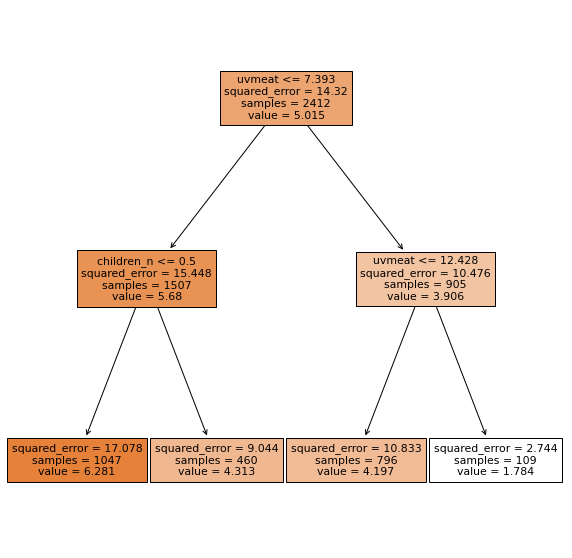

In [159]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
# Your code here
plt.figure(figsize=(10,10))
plot_tree(estimator, max_depth=2, filled=True, feature_names=X.columns)
plt.show()

## Random Forest Multivariate Regresson
Create a Random forest regressor and fit it on the complete dataset.

For simplicity use the max_depth found in the Decision tree regressor to perform a cross validation and find the best depth for this model.

In [167]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(random_state=random_state)
clf = GridSearchCV(
    estimator,
    param_grid=[{'max_depth': np.arange(1, max_depth+1)}],
    scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print(f"The optimal maximum depth for the trees in the random forest is {clf.best_params_['max_depth']}")

The optimal maximum depth for the trees in the random forest is 4


In [171]:
estimator = clf.best_estimator_
y_test_pred = estimator.predict(X_test)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Random Forest Regression - RMSE = {round(rmse, 2)}")

Random Forest Regression - RMSE = 3.58


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 
- the p-value suggests the acceptance of both models
### Decision Tree and Random Forest regression
- Decistion Tree has an RMSE slightly higher than multivariate linear regression
- Random Forest has an RMSE slightly lower than multivariate linear regression


## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with the other two columns and comment the results